<a href="https://colab.research.google.com/github/ChaerinKim12/codetree-TILs/blob/main/Mission2_%EC%B1%84%EB%A6%B0_0910.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# =============================================================================
# 셸 1: 환경 설정 및 라이브러리 설치
# =============================================================================

# GPU 확인 및 필요 라이브러리 설치
!nvidia-smi
!pip install timm opencv-python seaborn

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torch.cuda.amp import autocast, GradScaler
import torch.utils.checkpoint as checkpoint

import timm
import json
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 사용 중인 장치: {device}")
print(f"🔥 GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Wed Sep 10 05:05:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# =============================================================================
# 셸 2: 데이터 경로 설정 및 확인
# =============================================================================

# 데이터 경로 설정
TRAIN_IMG_DIR = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/images/train"
VALID_IMG_DIR = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/images/valid"
TRAIN_JSON_PATH = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/labels/train"
VALID_JSON_PATH = "/content/drive/MyDrive/dataset_mission2/HeightEstimation/labels/valid"

# 체크포인트 저장 경로
CHECKPOINT_DIR = "/content/drive/MyDrive/dataset_mission2/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# 경로 및 파일 개수 확인
print("📁 데이터셋 확인:")
print(f"Train images: {len(os.listdir(TRAIN_IMG_DIR))}개")
print(f"Valid images: {len(os.listdir(VALID_IMG_DIR))}개")
print(f"Train labels: {len(os.listdir(TRAIN_JSON_PATH))}개 JSON 파일")
print(f"Valid labels: {len(os.listdir(VALID_JSON_PATH))}개 JSON 파일")


📁 데이터셋 확인:
Train images: 8053개
Valid images: 1007개
Train labels: 7338개 JSON 파일
Valid labels: 1개 JSON 파일


In [3]:
# =============================================================================
# 셸 2-1: 압축 파일 해제 및 재확인
# =============================================================================

import zipfile
import os

# Valid labels 폴더 내용 확인
print("📂 Valid labels 폴더 내용:")
for item in os.listdir(VALID_JSON_PATH):
    print(f"  - {item}")

# ZIP 파일 찾기 및 압축 해제
for item in os.listdir(VALID_JSON_PATH):
    if item.endswith('.zip'):
        zip_path = os.path.join(VALID_JSON_PATH, item)
        print(f"\n📦 압축 파일 발견: {item}")
        print(f"📦 압축 해제 중...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(VALID_JSON_PATH)

        print(f"✅ 압축 해제 완료!")

        # 원본 ZIP 파일 삭제 (선택사항)
        # os.remove(zip_path)

# 압축 해제 후 재확인
print("\n📁 압축 해제 후 데이터셋 재확인:")
print(f"Train images: {len(os.listdir(TRAIN_IMG_DIR))}개")
print(f"Valid images: {len(os.listdir(VALID_IMG_DIR))}개")
print(f"Train labels: {len([f for f in os.listdir(TRAIN_JSON_PATH) if f.endswith('.json')])}개 JSON 파일")
print(f"Valid labels: {len([f for f in os.listdir(VALID_JSON_PATH) if f.endswith('.json')])}개 JSON 파일")

# Valid labels 폴더 내용 다시 확인
print("\n📂 Valid labels 폴더 내용 (압축 해제 후):")
for item in os.listdir(VALID_JSON_PATH):
    if item.endswith('.json'):
        print(f"  ✅ {item}")
    else:
        print(f"  📁 {item}")

📂 Valid labels 폴더 내용:
  - VL_KS_LINE.zip

📦 압축 파일 발견: VL_KS_LINE.zip
📦 압축 해제 중...
✅ 압축 해제 완료!

📁 압축 해제 후 데이터셋 재확인:
Train images: 8053개
Valid images: 1007개
Train labels: 7337개 JSON 파일
Valid labels: 1006개 JSON 파일

📂 Valid labels 폴더 내용 (압축 해제 후):
  📁 VL_KS_LINE.zip
  ✅ K3A_CHN_20180125050347_5.json
  ✅ K3A_CHN_20170115051130_1.json
  ✅ K3A_CHN_20170210052214_15.json
  ✅ K3A_CHN_20180309051740_43.json
  ✅ K3A_CHN_20170123052151_1.json
  ✅ K3A_CHN_20180328050206_6.json
  ✅ K3A_CHN_20170723050144_3.json
  ✅ K3A_CHN_20170423052236_3.json
  ✅ K3A_CHN_20170123052151_14.json
  ✅ K3A_CHN_20170423052236_20.json
  ✅ K3A_CHN_20170723050144_28.json
  ✅ K3A_CHN_20181002045733_16.json
  ✅ K3A_CHN_20190801050257_34.json
  ✅ K3A_CHN_20180328050206_3.json
  ✅ K3A_CHN_20180809050333_43.json
  ✅ K3A_CHN_20180809050333_12.json
  ✅ K3A_CHN_20170123052151_22.json
  ✅ K3A_CHN_20170723050144_25.json
  ✅ K3A_CHN_20181019050903_32.json
  ✅ K3A_CHN_20180328050206_4.json
  ✅ K3A_CHN_20180809050333_17.json
  ✅ K3A_CH

In [4]:
# 압축 해제 후 재확인
print("\n📁 압축 해제 후 데이터셋 재확인:")
print(f"Train images: {len(os.listdir(TRAIN_IMG_DIR))}개")
print(f"Valid images: {len(os.listdir(VALID_IMG_DIR))}개")
print(f"Train labels: {len([f for f in os.listdir(TRAIN_JSON_PATH) if f.endswith('.json')])}개 JSON 파일")
print(f"Valid labels: {len([f for f in os.listdir(VALID_JSON_PATH) if f.endswith('.json')])}개 JSON 파일")


📁 압축 해제 후 데이터셋 재확인:
Train images: 8053개
Valid images: 1007개
Train labels: 7337개 JSON 파일
Valid labels: 1006개 JSON 파일


In [5]:
# =============================================================================
# 셸 3: JSON 데이터 로딩 및 EDA
# =============================================================================

def load_json_data(json_dir):
    """여러 JSON 파일을 하나로 합치기"""
    all_data = {}
    for json_file in os.listdir(json_dir):
        if json_file.endswith('.json'):
            file_path = os.path.join(json_dir, json_file)
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                all_data.update(data)
    return all_data

# JSON 데이터 로딩
print("📊 JSON 데이터 로딩 중...")
train_labels = load_json_data(TRAIN_JSON_PATH)
valid_labels = load_json_data(VALID_JSON_PATH)

print(f"📊 Train 라벨 수: {len(train_labels)}개")
print(f"📊 Valid 라벨 수: {len(valid_labels)}개")

# 샘플 데이터 확인
sample_key = list(train_labels.keys())[0]
sample_data = train_labels[sample_key]
print(f"\n🔍 샘플 데이터 구조:")
print(json.dumps(sample_data, indent=2, ensure_ascii=False))

📊 JSON 데이터 로딩 중...
📊 Train 라벨 수: 7337개
📊 Valid 라벨 수: 1006개

🔍 샘플 데이터 구조:
{
  "filename": "K3_CHN_20210518050720_8.jpg",
  "size": 61972,
  "regions": [
    {
      "shape_attributes": {
        "name": "polyline",
        "all_points_x": [
          125,
          192
        ],
        "all_points_y": [
          404,
          457
        ]
      },
      "region_attributes": {
        "chi_id": "1",
        "chi_height_m": "138.78"
      }
    },
    {
      "shape_attributes": {
        "name": "polyline",
        "all_points_x": [
          229,
          262
        ],
        "all_points_y": [
          383,
          411
        ]
      },
      "region_attributes": {
        "chi_id": "2",
        "chi_height_m": "70.31"
      }
    }
  ],
  "file_attributes": {
    "img_id": "K3_CHN_20210518050720_8",
    "img_height": "512",
    "img_width": "512",
    "img_resolution": "0.7",
    "img_time": "21051805",
    "img_roll_tilt": "-16.71936769",
    "img_pitch_tilt": "-17.167585"

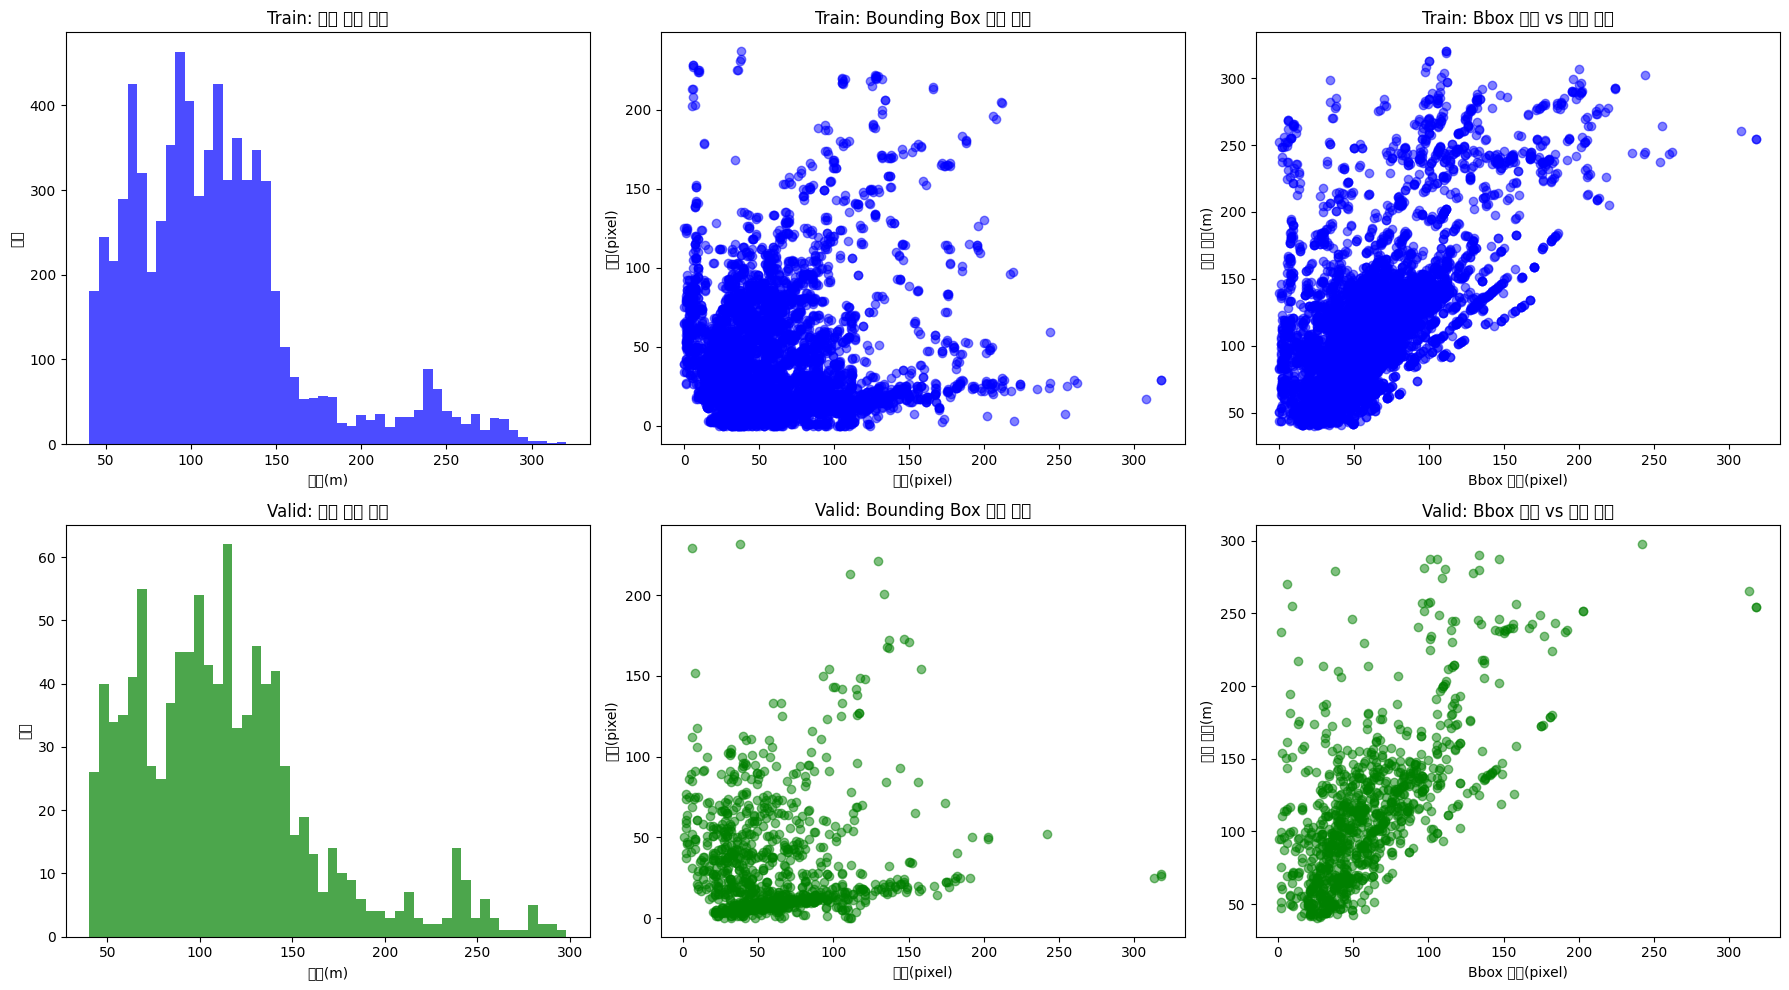

📈 Train 높이 통계: 평균=115.1m, 표준편차=51.8m, 범위=40.3-320.3m
📈 Valid 높이 통계: 평균=113.7m, 표준편차=50.4m, 범위=40.4-298.1m
📏 Train Bbox 크기: 평균 너비=60.2px, 평균 높이=35.5px
📏 Valid Bbox 크기: 평균 너비=60.7px, 평균 높이=33.6px


In [6]:
# =============================================================================
# 셸 4: 데이터 분포 분석 및 시각화
# =============================================================================

def analyze_dataset(labels_dict, title="Dataset"):
    """데이터셋 분석"""
    heights = []
    bbox_sizes = []

    for data in labels_dict.values():
        if 'regions' in data and len(data['regions']) > 0:
            region = data['regions'][0]  # 첫 번째 굴뚝

            # 높이 정보
            height = float(region['region_attributes']['chi_height_m'])
            heights.append(height)

            # Bounding box 크기 계산
            x_coords = region['shape_attributes']['all_points_x']
            y_coords = region['shape_attributes']['all_points_y']
            bbox_width = max(x_coords) - min(x_coords)
            bbox_height = max(y_coords) - min(y_coords)
            bbox_sizes.append((bbox_width, bbox_height))

    return heights, bbox_sizes

# 데이터 분석
train_heights, train_bbox_sizes = analyze_dataset(train_labels, "Train")
valid_heights, valid_bbox_sizes = analyze_dataset(valid_labels, "Valid")

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Train 데이터 분석
axes[0, 0].hist(train_heights, bins=50, alpha=0.7, color='blue')
axes[0, 0].set_title('Train: 굴뚝 높이 분포')
axes[0, 0].set_xlabel('높이(m)')
axes[0, 0].set_ylabel('빈도')

train_widths, train_heights_bbox = zip(*train_bbox_sizes)
axes[0, 1].scatter(train_widths, train_heights_bbox, alpha=0.5, color='blue')
axes[0, 1].set_title('Train: Bounding Box 크기 분포')
axes[0, 1].set_xlabel('너비(pixel)')
axes[0, 1].set_ylabel('높이(pixel)')

axes[0, 2].scatter(train_widths, train_heights, alpha=0.5, color='blue')
axes[0, 2].set_title('Train: Bbox 너비 vs 굴뚝 높이')
axes[0, 2].set_xlabel('Bbox 너비(pixel)')
axes[0, 2].set_ylabel('굴뚝 높이(m)')

# Valid 데이터 분석
axes[1, 0].hist(valid_heights, bins=50, alpha=0.7, color='green')
axes[1, 0].set_title('Valid: 굴뚝 높이 분포')
axes[1, 0].set_xlabel('높이(m)')
axes[1, 0].set_ylabel('빈도')

valid_widths, valid_heights_bbox = zip(*valid_bbox_sizes)
axes[1, 1].scatter(valid_widths, valid_heights_bbox, alpha=0.5, color='green')
axes[1, 1].set_title('Valid: Bounding Box 크기 분포')
axes[1, 1].set_xlabel('너비(pixel)')
axes[1, 1].set_ylabel('높이(pixel)')

axes[1, 2].scatter(valid_widths, valid_heights, alpha=0.5, color='green')
axes[1, 2].set_title('Valid: Bbox 너비 vs 굴뚝 높이')
axes[1, 2].set_xlabel('Bbox 너비(pixel)')
axes[1, 2].set_ylabel('굴뚝 높이(m)')

plt.tight_layout()
plt.show()

# 통계 정보
print(f"📈 Train 높이 통계: 평균={np.mean(train_heights):.1f}m, 표준편차={np.std(train_heights):.1f}m, 범위={min(train_heights):.1f}-{max(train_heights):.1f}m")
print(f"📈 Valid 높이 통계: 평균={np.mean(valid_heights):.1f}m, 표준편차={np.std(valid_heights):.1f}m, 범위={min(valid_heights):.1f}-{max(valid_heights):.1f}m")
print(f"📏 Train Bbox 크기: 평균 너비={np.mean(train_widths):.1f}px, 평균 높이={np.mean(train_heights_bbox):.1f}px")
print(f"📏 Valid Bbox 크기: 평균 너비={np.mean(valid_widths):.1f}px, 평균 높이={np.mean(valid_heights_bbox):.1f}px")

In [8]:
# =============================================================================
# 셸 5: ResNet 모델 정의 및 메모리 테스트
# =============================================================================

class OptimizedResNet(nn.Module):
    def __init__(self, model_name='resnet34', use_checkpointing=True):
        super().__init__()
        self.use_checkpointing = use_checkpointing
        self.model_name = model_name

        # 기본 ResNet만 사용
        self.backbone = models.__dict__[model_name](pretrained=True)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1)
        self.is_timm_model = False

    def forward(self, x):
        # ResNet의 경우 gradient checkpointing 적용
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        if self.use_checkpointing and self.training:
            x = checkpoint.checkpoint(self.backbone.layer1, x)
            x = checkpoint.checkpoint(self.backbone.layer2, x)
            x = checkpoint.checkpoint(self.backbone.layer3, x)
            x = checkpoint.checkpoint(self.backbone.layer4, x)
        else:
            x = self.backbone.layer1(x)
            x = self.backbone.layer2(x)
            x = self.backbone.layer3(x)
            x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)
        return x

def find_optimal_batch_size(model, input_shape=(3, 224, 224)):
    """T4 GPU에 맞는 최적 배치 크기 찾기"""
    model = model.cuda()
    model.train()

    for batch_size in [128, 64, 32, 16, 8]:
        try:
            # 메모리 정리
            torch.cuda.empty_cache()

            # 테스트 배치 생성
            dummy_input = torch.randn(batch_size, *input_shape).cuda()
            dummy_target = torch.randn(batch_size, 1).cuda()

            # Forward + Backward 테스트
            with autocast():
                output = model(dummy_input)
                loss = nn.MSELoss()(output, dummy_target)

            # Backward pass 테스트 (실제 메모리 사용량 확인)
            scaler = GradScaler()
            scaler.scale(loss).backward()

            print(f"✅ Batch size {batch_size}: 메모리 사용 가능")
            torch.cuda.empty_cache()
            return batch_size

        except RuntimeError as e:
            if "out of memory" in str(e):
                print(f"❌ Batch size {batch_size}: OOM")
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    return 4  # 최소 배치 크기

# ResNet 버전들 테스트 (우리의 메인 실험)
resnet_models = [
    'resnet18',    # 11M params - 가장 가벼움
    'resnet34',    # 21M params
    'resnet50',    # 25M params
    'resnet101',   # 44M params - T4에서 테스트 필요
]

print("🔧 ResNet 버전별 파라미터 수:")
model_info = {}
for model_name in resnet_models:
    try:
        model = OptimizedResNet(model_name)
        param_count = sum(p.numel() for p in model.parameters())
        model_info[model_name] = param_count
        print(f"✅ {model_name}: {param_count:,} parameters")
        del model
    except Exception as e:
        print(f"❌ {model_name}: {e}")

# ResNet18로 최적 배치 크기 찾기 (가장 가벼운 모델)
print(f"\n🔍 ResNet18로 최적 배치 크기 찾는 중...")
test_model = OptimizedResNet('resnet18')
optimal_batch_size = find_optimal_batch_size(test_model)
print(f"🎯 최적 배치 크기: {optimal_batch_size}")
del test_model

# 각 ResNet 버전별로 메모리 사용량도 체크
print(f"\n🔍 각 ResNet 모델별 메모리 체크:")
batch_sizes = {}
for model_name in resnet_models:
    try:
        torch.cuda.empty_cache()
        model = OptimizedResNet(model_name)
        batch_size = find_optimal_batch_size(model)
        batch_sizes[model_name] = batch_size
        print(f"📊 {model_name}: 최대 배치 크기 = {batch_size}")
        del model
    except Exception as e:
        print(f"❌ {model_name}: {e}")
        batch_sizes[model_name] = 8  # 기본값

print(f"\n📊 ResNet 모델별 요약:")
for model_name in resnet_models:
    if model_name in model_info and model_name in batch_sizes:
        print(f"{model_name}: {model_info[model_name]:,} params, 배치크기 {batch_sizes[model_name]}")

🔧 ResNet 버전별 파라미터 수:
✅ resnet18: 11,177,025 parameters
✅ resnet34: 21,285,185 parameters
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 156MB/s]


✅ resnet50: 23,510,081 parameters
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


100%|██████████| 171M/171M [00:01<00:00, 173MB/s]


✅ resnet101: 42,502,209 parameters

🔍 ResNet18로 최적 배치 크기 찾는 중...
✅ Batch size 128: 메모리 사용 가능
🎯 최적 배치 크기: 128

🔍 각 ResNet 모델별 메모리 체크:
✅ Batch size 128: 메모리 사용 가능
📊 resnet18: 최대 배치 크기 = 128
✅ Batch size 128: 메모리 사용 가능
📊 resnet34: 최대 배치 크기 = 128
✅ Batch size 128: 메모리 사용 가능
📊 resnet50: 최대 배치 크기 = 128
✅ Batch size 128: 메모리 사용 가능
📊 resnet101: 최대 배치 크기 = 128

📊 ResNet 모델별 요약:
resnet18: 11,177,025 params, 배치크기 128
resnet34: 21,285,185 params, 배치크기 128
resnet50: 23,510,081 params, 배치크기 128
resnet101: 42,502,209 params, 배치크기 128


🔧 개선된 Dataset 생성 중...
📊 Dataset 생성 완료:
   - 유효한 샘플 수: 4,219개
   - 필터링된 작은 bbox: 5413개
   - 패딩 크기: 25px
   - 최소 bbox 크기: 20px
📊 Dataset 생성 완료:
   - 유효한 샘플 수: 554개
   - 필터링된 작은 bbox: 769개
   - 패딩 크기: 25px
   - 최소 bbox 크기: 20px

🖼️ 개선된 샘플 시각화:


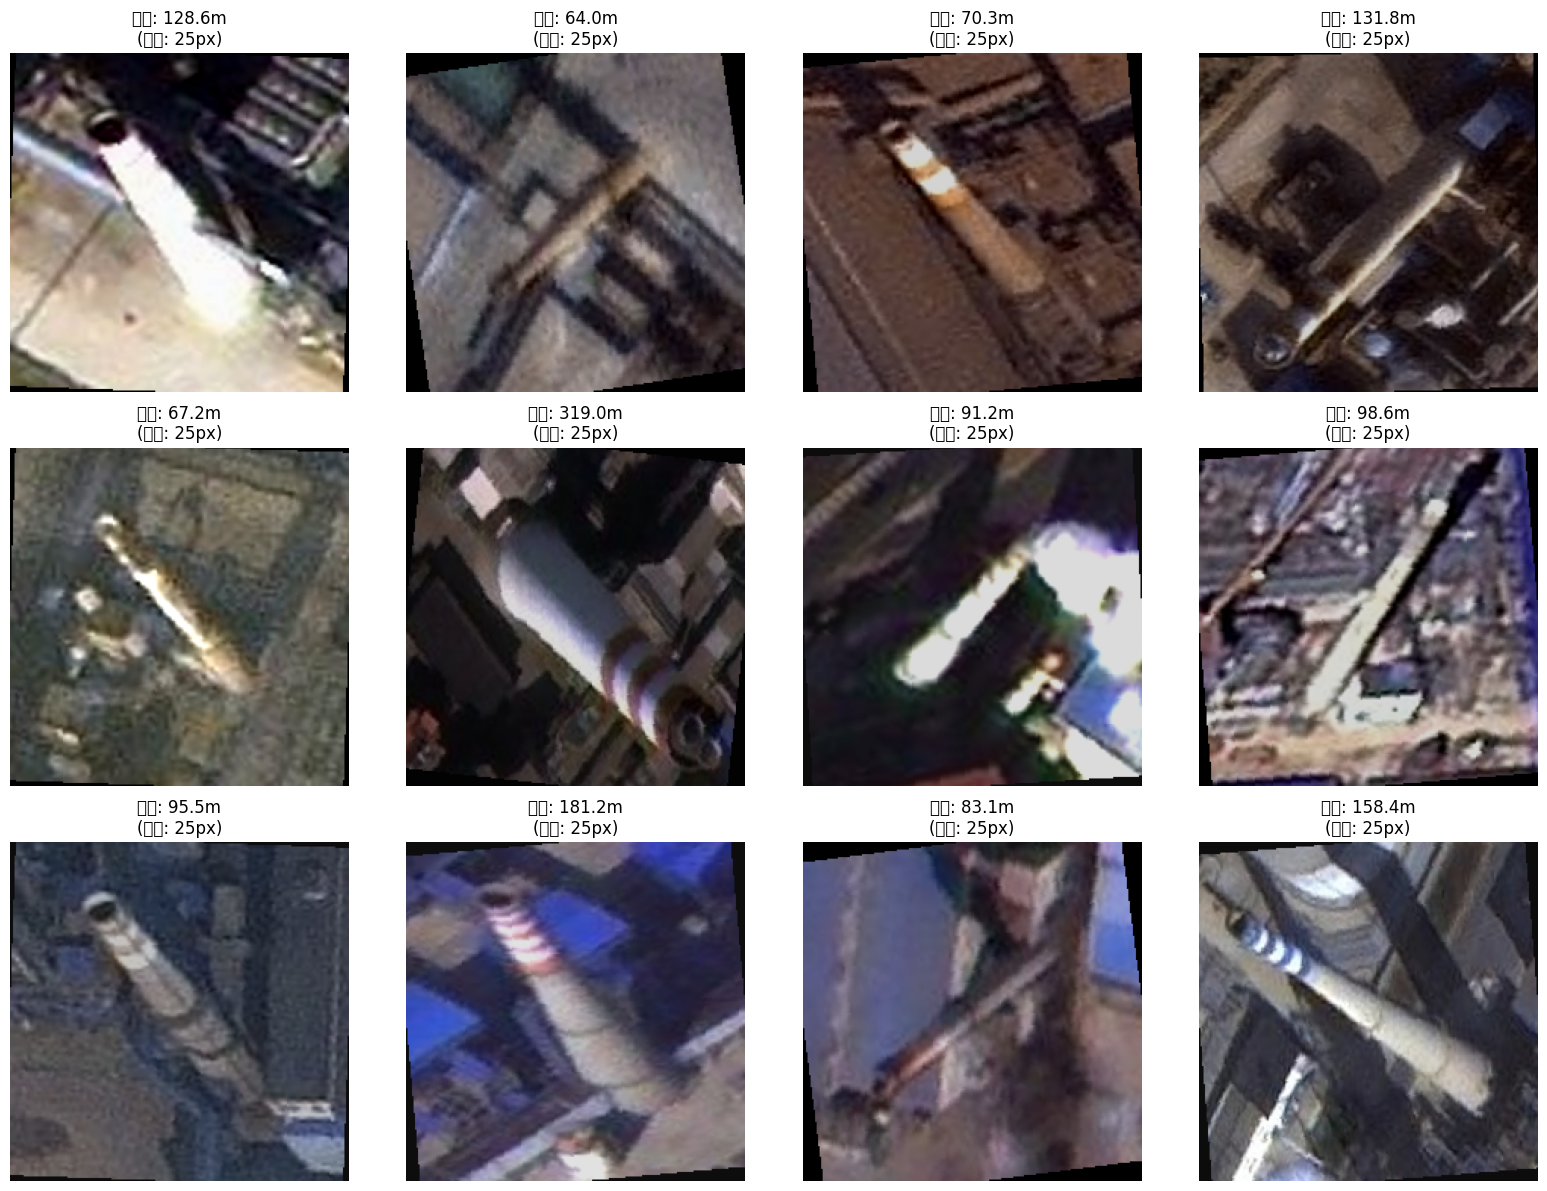


📈 개선된 데이터셋 통계:
Train 샘플 수: 4,219개
Valid 샘플 수: 554개
총 샘플 수: 4,773개

✅ 개선사항 확인:
1. 패딩 크기: 15px → 25px 증가
2. 최소 bbox 크기: 20px 이상만 사용
3. 최소 crop 크기: 50px 보장
4. Interpolation: BICUBIC 사용 (더 좋은 품질)
5. 모든 굴뚝 활용: 데이터 양 증가

📊 필터링 후 높이 분포:
Train 평균 높이: 124.8m
Valid 평균 높이: 124.7m

💾 메모리 사용량:
샘플 배치 크기 (8개): torch.Size([8, 3, 224, 224])
메모리 사용량: 4.6 MB
배치 크기 128 예상 메모리: 73.5 MB

🎯 다음 단계: 배치 크기 128로 DataLoader 생성 준비 완료!


In [9]:
# =============================================================================
# 셸 6: 개선된 Custom Dataset 클래스 (작은 bbox 문제 해결)
# =============================================================================

class ChimneyDataset(Dataset):
    def __init__(self, image_dir, labels_dict, transform=None,
                 padding=25,           # 패딩 증가 (15 → 25)
                 min_bbox_size=20,     # 최소 bbox 크기
                 use_all_chimneys=True, # 모든 굴뚝 사용
                 filter_small_boxes=True): # 작은 박스 필터링

        self.image_dir = image_dir
        self.labels_dict = labels_dict
        self.transform = transform
        self.padding = padding
        self.min_bbox_size = min_bbox_size
        self.filter_small_boxes = filter_small_boxes

        # 유효한 데이터만 필터링
        self.valid_samples = []
        filtered_count = 0

        for key, data in labels_dict.items():
            if 'regions' in data and len(data['regions']) > 0:
                filename = data['filename']
                image_path = os.path.join(image_dir, filename)

                if os.path.exists(image_path):
                    # 모든 굴뚝 처리 또는 첫 번째만
                    if use_all_chimneys:
                        for region_idx, region in enumerate(data['regions']):
                            # Bbox 크기 체크
                            x_coords = region['shape_attributes']['all_points_x']
                            y_coords = region['shape_attributes']['all_points_y']
                            bbox_width = max(x_coords) - min(x_coords)
                            bbox_height = max(y_coords) - min(y_coords)

                            # 작은 bbox 필터링
                            if self.filter_small_boxes:
                                if bbox_width >= min_bbox_size and bbox_height >= min_bbox_size:
                                    self.valid_samples.append((key, data, region_idx))
                                else:
                                    filtered_count += 1
                            else:
                                self.valid_samples.append((key, data, region_idx))
                    else:
                        # 첫 번째 굴뚝만 사용
                        region = data['regions'][0]
                        x_coords = region['shape_attributes']['all_points_x']
                        y_coords = region['shape_attributes']['all_points_y']
                        bbox_width = max(x_coords) - min(x_coords)
                        bbox_height = max(y_coords) - min(y_coords)

                        if not self.filter_small_boxes or (bbox_width >= min_bbox_size and bbox_height >= min_bbox_size):
                            self.valid_samples.append((key, data, 0))
                        else:
                            filtered_count += 1

        print(f"📊 Dataset 생성 완료:")
        print(f"   - 유효한 샘플 수: {len(self.valid_samples):,}개")
        print(f"   - 필터링된 작은 bbox: {filtered_count}개")
        print(f"   - 패딩 크기: {padding}px")
        print(f"   - 최소 bbox 크기: {min_bbox_size}px")

    def __len__(self):
        return len(self.valid_samples)

    def __getitem__(self, idx):
        key, data, region_idx = self.valid_samples[idx]

        try:
            # 이미지 로드
            filename = data['filename']
            image_path = os.path.join(self.image_dir, filename)
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"이미지를 읽을 수 없습니다: {image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # 해당 굴뚝 정보 추출
            region = data['regions'][region_idx]
            x_coords = region['shape_attributes']['all_points_x']
            y_coords = region['shape_attributes']['all_points_y']
            height = float(region['region_attributes']['chi_height_m'])

            # Bounding box 계산
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # 패딩 추가 (context 정보 보존 + 해상도 손실 완화)
            h, w = image.shape[:2]
            x_min_padded = max(0, x_min - self.padding)
            y_min_padded = max(0, y_min - self.padding)
            x_max_padded = min(w, x_max + self.padding)
            y_max_padded = min(h, y_max + self.padding)

            # 최소 크기 보장 (정사각형에 가깝게)
            crop_width = x_max_padded - x_min_padded
            crop_height = y_max_padded - y_min_padded

            # 너무 작으면 더 큰 영역으로 확장
            min_crop_size = 50
            if crop_width < min_crop_size or crop_height < min_crop_size:
                center_x = (x_min + x_max) // 2
                center_y = (y_min + y_max) // 2
                half_size = min_crop_size // 2

                x_min_padded = max(0, center_x - half_size)
                y_min_padded = max(0, center_y - half_size)
                x_max_padded = min(w, center_x + half_size)
                y_max_padded = min(h, center_y + half_size)

            # 이미지 crop
            cropped_image = image[y_min_padded:y_max_padded, x_min_padded:x_max_padded]

            # 크기 체크
            if cropped_image.size == 0:
                raise ValueError("Cropped image is empty")

            # PIL Image로 변환
            cropped_image = Image.fromarray(cropped_image)

            # Transform 적용
            if self.transform:
                cropped_image = self.transform(cropped_image)

            return cropped_image, torch.tensor(height, dtype=torch.float32)

        except Exception as e:
            print(f"⚠️ Error loading sample {idx}: {e}")
            # 에러 발생 시 다른 샘플 반환
            return self.__getitem__((idx + 1) % len(self.valid_samples))

# 개선된 Transform 정의 (더 좋은 interpolation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),  # 더 좋은 보간
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),  # 더 좋은 보간
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성 (모든 굴뚝 활용)
print("🔧 개선된 Dataset 생성 중...")
train_dataset = ChimneyDataset(
    TRAIN_IMG_DIR,
    train_labels,
    train_transform,
    padding=25,              # 패딩 증가
    min_bbox_size=20,        # 최소 bbox 크기
    use_all_chimneys=True,   # 모든 굴뚝 사용
    filter_small_boxes=True  # 작은 박스 필터링
)

valid_dataset = ChimneyDataset(
    VALID_IMG_DIR,
    valid_labels,
    valid_transform,
    padding=25,              # 패딩 증가
    min_bbox_size=20,        # 최소 bbox 크기
    use_all_chimneys=True,   # 모든 굴뚝 사용
    filter_small_boxes=True  # 작은 박스 필터링
)

# 개선된 샘플 시각화 (패딩 효과 확인)
print("\n🖼️ 개선된 샘플 시각화:")
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(12):
    idx = np.random.randint(0, len(train_dataset))
    image, height = train_dataset[idx]

    # 정규화 해제
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    image_denorm = image * std + mean
    image_denorm = torch.clamp(image_denorm, 0, 1)

    axes[i].imshow(image_denorm.permute(1, 2, 0))
    axes[i].set_title(f'높이: {height:.1f}m\n(패딩: 25px)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# 개선된 데이터셋 통계
print(f"\n📈 개선된 데이터셋 통계:")
print(f"Train 샘플 수: {len(train_dataset):,}개")
print(f"Valid 샘플 수: {len(valid_dataset):,}개")
print(f"총 샘플 수: {len(train_dataset) + len(valid_dataset):,}개")

# 작은 이미지 문제 해결 정도 확인
print(f"\n✅ 개선사항 확인:")
print(f"1. 패딩 크기: 15px → 25px 증가")
print(f"2. 최소 bbox 크기: 20px 이상만 사용")
print(f"3. 최소 crop 크기: 50px 보장")
print(f"4. Interpolation: BICUBIC 사용 (더 좋은 품질)")
print(f"5. 모든 굴뚝 활용: 데이터 양 증가")

# 높이 분포 재확인 (필터링 후)
train_heights_filtered = []
valid_heights_filtered = []

for i in range(min(len(train_dataset), 1000)):  # 샘플링해서 확인
    _, height = train_dataset[i]
    train_heights_filtered.append(height.item())

for i in range(min(len(valid_dataset), 200)):   # 샘플링해서 확인
    _, height = valid_dataset[i]
    valid_heights_filtered.append(height.item())

print(f"\n📊 필터링 후 높이 분포:")
print(f"Train 평균 높이: {np.mean(train_heights_filtered):.1f}m")
print(f"Valid 평균 높이: {np.mean(valid_heights_filtered):.1f}m")

# 메모리 사용량 체크
sample_batch = torch.stack([train_dataset[i][0] for i in range(8)])
print(f"\n💾 메모리 사용량:")
print(f"샘플 배치 크기 (8개): {sample_batch.shape}")
print(f"메모리 사용량: {sample_batch.numel() * sample_batch.element_size() / 1024 / 1024:.1f} MB")
print(f"배치 크기 128 예상 메모리: {sample_batch.numel() * sample_batch.element_size() * 16 / 1024 / 1024:.1f} MB")

print(f"\n🎯 다음 단계: 배치 크기 128로 DataLoader 생성 준비 완료!")

In [10]:
# =============================================================================
# 셸 7: DataLoader 및 학습 준비
# =============================================================================

# 최적화된 DataLoader 생성 (배치 크기 128)
print("🔧 DataLoader 생성 중...")

train_loader = DataLoader(
    train_dataset,
    batch_size=128,  # 모든 ResNet에서 가능한 최대 배치 크기
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    drop_last=True  # 마지막 배치가 작을 때 제거
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=128,  # 동일한 배치 크기
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

print(f"📊 DataLoader 정보:")
print(f"Train batches: {len(train_loader):,}개 (배치 크기: 128)")
print(f"Valid batches: {len(valid_loader):,}개 (배치 크기: 128)")
print(f"Train 실제 샘플 수: {len(train_loader) * 128:,}개")
print(f"Valid 실제 샘플 수: {len(valid_loader) * 128 + len(valid_dataset) % 128:,}개")

# 개선된 학습 함수들 정의
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """개선된 학습 함수"""
    model.train()
    total_loss = 0
    predictions = []
    targets = []

    # 진행률 표시를 위한 변수
    total_batches = len(train_loader)
    log_interval = max(1, total_batches // 10)  # 10번 로그 출력

    for batch_idx, (images, heights) in enumerate(train_loader):
        images, heights = images.to(device, non_blocking=True), heights.to(device, non_blocking=True).unsqueeze(1)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, heights)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        predictions.extend(outputs.detach().cpu().numpy())
        targets.extend(heights.detach().cpu().numpy())

        # 진행률 출력
        if batch_idx % log_interval == 0:
            progress = (batch_idx + 1) / total_batches * 100
            print(f'    진행률: {progress:5.1f}% ({batch_idx+1:3d}/{total_batches:3d}) - Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return avg_loss, rmse, mae, r2

def validate_epoch(model, valid_loader, criterion, device):
    """개선된 검증 함수"""
    model.eval()
    total_loss = 0
    predictions = []
    targets = []

    with torch.no_grad():
        for images, heights in valid_loader:
            images, heights = images.to(device, non_blocking=True), heights.to(device, non_blocking=True).unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, heights)

            total_loss += loss.item()
            predictions.extend(outputs.cpu().numpy())
            targets.extend(heights.cpu().numpy())

    avg_loss = total_loss / len(valid_loader)
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)

    return avg_loss, rmse, mae, r2, predictions, targets

# ResNet 빠른 실험 함수 정의
def quick_experiment_resnet(model_name, epochs=5):
    """ResNet 빠른 성능 비교 (5 epochs)"""
    print(f"\n🚀 {model_name} 빠른 실험 시작 (5 epochs)...")

    # 모델 생성
    model = OptimizedResNet(model_name).to(device)
    param_count = sum(p.numel() for p in model.parameters())
    print(f"   📊 파라미터 수: {param_count:,}개")

    # 최적화 설정 (빠른 실험용)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_rmse = float('inf')
    results = []

    for epoch in range(epochs):
        # 학습
        train_loss, train_rmse, train_mae, train_r2 = train_epoch(
            model, train_loader, optimizer, criterion, scaler, device
        )

        # 검증
        val_loss, val_rmse, val_mae, val_r2, _, _ = validate_epoch(
            model, valid_loader, criterion, device
        )

        scheduler.step()

        if val_rmse < best_rmse:
            best_rmse = val_rmse

        results.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_rmse': train_rmse,
            'val_loss': val_loss,
            'val_rmse': val_rmse,
            'val_r2': val_r2
        })

        print(f'   Epoch {epoch+1}/{epochs}: Train RMSE: {train_rmse:5.2f}, Val RMSE: {val_rmse:5.2f}, Val R²: {val_r2:.3f}')

    # 메모리 정리
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

    return best_rmse, results

# DataLoader 테스트
print(f"\n🔍 DataLoader 테스트:")
try:
    # 첫 번째 배치 로드 테스트
    sample_batch = next(iter(train_loader))
    images, heights = sample_batch
    print(f"✅ 배치 로딩 성공:")
    print(f"   이미지 shape: {images.shape}")
    print(f"   높이 shape: {heights.shape}")
    print(f"   높이 범위: {heights.min():.1f}m ~ {heights.max():.1f}m")
    print(f"   GPU 메모리 사용량: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

    # GPU로 전송 테스트
    images_gpu = images.to(device)
    heights_gpu = heights.to(device)
    print(f"✅ GPU 전송 성공 - 메모리: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")

    # 메모리 정리
    del images, heights, images_gpu, heights_gpu
    torch.cuda.empty_cache()

except Exception as e:
    print(f"❌ DataLoader 에러: {e}")

# 학습 환경 최종 확인
print(f"\n🎯 학습 환경 최종 확인:")
print(f"✅ Device: {device}")
print(f"✅ GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"✅ 배치 크기: 128 (모든 ResNet에서 사용 가능)")
print(f"✅ Train batches: {len(train_loader)}개")
print(f"✅ Valid batches: {len(valid_loader)}개")
print(f"✅ Mixed Precision: 활성화")
print(f"✅ Gradient Checkpointing: 활성화")

print(f"\n🚀 다음 단계: ResNet 모델 비교 실험 (셸 8번)")
print(f"   예상 소요 시간: 15-20분 (4개 모델 × 5 epochs)")
print(f"   실험 모델: ResNet18, ResNet34, ResNet50, ResNet101")


🔧 DataLoader 생성 중...
📊 DataLoader 정보:
Train batches: 32개 (배치 크기: 128)
Valid batches: 5개 (배치 크기: 128)
Train 실제 샘플 수: 4,096개
Valid 실제 샘플 수: 682개

🔍 DataLoader 테스트:
✅ 배치 로딩 성공:
   이미지 shape: torch.Size([128, 3, 224, 224])
   높이 shape: torch.Size([128])
   높이 범위: 40.6m ~ 279.7m
   GPU 메모리 사용량: 0.02 GB
✅ GPU 전송 성공 - 메모리: 0.09 GB

🎯 학습 환경 최종 확인:
✅ Device: cuda
✅ GPU 메모리: 14.7 GB
✅ 배치 크기: 128 (모든 ResNet에서 사용 가능)
✅ Train batches: 32개
✅ Valid batches: 5개
✅ Mixed Precision: 활성화
✅ Gradient Checkpointing: 활성화

🚀 다음 단계: ResNet 모델 비교 실험 (셸 8번)
   예상 소요 시간: 15-20분 (4개 모델 × 5 epochs)
   실험 모델: ResNet18, ResNet34, ResNet50, ResNet101


In [13]:
# DataLoader 재생성 (num_workers=0으로 수정)
print("🔧 DataLoader 재생성 중...")

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=0,  # Colab에서는 0이 안전
    pin_memory=True
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=0,  # Colab에서는 0이 안전
    pin_memory=True
)

print("✅ DataLoader 재생성 완료!")
print(f"📊 Train batches: {len(train_loader)}")
print(f"📊 Valid batches: {len(valid_loader)}")

# 테스트
try:
    sample_batch = next(iter(train_loader))
    print("✅ DataLoader 테스트 성공!")
except Exception as e:
    print(f"❌ 여전히 에러: {e}")

🔧 DataLoader 재생성 중...
✅ DataLoader 재생성 완료!
📊 Train batches: 33
📊 Valid batches: 5
✅ DataLoader 테스트 성공!


In [14]:
# 환경 확인
print("🔍 실행 환경 확인:")
print(f"✓ Device: {device}")
print(f"✓ Train loader: {len(train_loader)} batches")
print(f"✓ Valid loader: {len(valid_loader)} batches")

# 함수 존재 확인
functions_to_check = ['train_epoch', 'validate_epoch', 'OptimizedResNet']
for func_name in functions_to_check:
    if func_name in globals():
        print(f"✓ {func_name}: 정의됨")
    else:
        print(f"❌ {func_name}: 정의되지 않음")

# 간단한 모델 생성 테스트
try:
    test_model = OptimizedResNet('resnet18')
    print("✓ OptimizedResNet 생성 가능")
    del test_model
except Exception as e:
    print(f"❌ OptimizedResNet 에러: {e}")

print("\n🚀 모든 확인이 완료되면 셸 8 실행 가능!")

🔍 실행 환경 확인:
✓ Device: cuda
✓ Train loader: 33 batches
✓ Valid loader: 5 batches
✓ train_epoch: 정의됨
✓ validate_epoch: 정의됨
✓ OptimizedResNet: 정의됨
✓ OptimizedResNet 생성 가능

🚀 모든 확인이 완료되면 셸 8 실행 가능!


In [15]:
# =============================================================================
# 셸 8: ResNet 모델 비교 실험 (빠른 스크리닝)
# =============================================================================

import time  # 시간 측정용

def quick_experiment_resnet(model_name, epochs=5):
    """ResNet 빠른 성능 비교"""
    print(f"\n🚀 {model_name} 빠른 실험 시작...")

    # 모델 생성
    model = OptimizedResNet(model_name).to(device)
    param_count = sum(p.numel() for p in model.parameters())
    print(f"   📊 파라미터 수: {param_count:,}개")

    # 최적화 설정
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scaler = GradScaler()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    best_rmse = float('inf')
    results = []

    for epoch in range(epochs):
        train_loss, train_rmse, train_mae, train_r2 = train_epoch(
            model, train_loader, optimizer, criterion, scaler, device
        )

        val_loss, val_rmse, val_mae, val_r2, _, _ = validate_epoch(
            model, valid_loader, criterion, device
        )

        scheduler.step()

        if val_rmse < best_rmse:
            best_rmse = val_rmse

        results.append({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_rmse': train_rmse,
            'val_loss': val_loss,
            'val_rmse': val_rmse,
            'val_r2': val_r2
        })

        print(f'   Epoch {epoch+1}/{epochs}: Train RMSE: {train_rmse:5.2f}, Val RMSE: {val_rmse:5.2f}, Val R²: {val_r2:.3f}')

    # 메모리 정리
    del model, optimizer, scheduler
    torch.cuda.empty_cache()

    return best_rmse, results

# ResNet 모델들만 실험
resnet_models = ['resnet18', 'resnet34', 'resnet50', 'resnet101']
resnet_results = {}
experiment_start_time = time.time()

print("🎯 ResNet 모델 비교 실험 시작!")
print("=" * 60)

for i, model_name in enumerate(resnet_models):
    print(f"\n[{i+1}/4] {model_name.upper()} 실험 진행 중...")
    print("-" * 50)

    try:
        torch.cuda.empty_cache()  # 메모리 정리
        model_start_time = time.time()

        best_rmse, results = quick_experiment_resnet(model_name, epochs=5)

        model_time = time.time() - model_start_time
        resnet_results[model_name] = {
            'best_rmse': best_rmse,
            'results': results,
            'experiment_time': model_time
        }
        print(f"✅ {model_name}: Best RMSE = {best_rmse:.2f}m (소요시간: {model_time/60:.1f}분)")

    except Exception as e:
        print(f"❌ {model_name}: Error - {e}")

# 전체 실험 시간
total_time = time.time() - experiment_start_time

# 결과 정렬 및 출력
print(f"\n" + "=" * 60)
print(f"🏁 ResNet 비교 실험 완료! (총 소요시간: {total_time/60:.1f}분)")
print("=" * 60)

print(f"\n📊 ResNet 성능 순위:")
print("-" * 50)
print(f"{'순위':<4} {'모델':<12} {'Best RMSE':<12} {'시간(분)':<8}")
print("-" * 50)

# RMSE 기준으로 정렬
sorted_models = sorted(resnet_results.items(), key=lambda x: x[1]['best_rmse'])

for rank, (model_name, result) in enumerate(sorted_models, 1):
    best_rmse = result['best_rmse']
    exp_time = result['experiment_time']

    medal = "🏆" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"{medal} {rank:<2} {model_name:<12} {best_rmse:<12.2f} {exp_time/60:<8.1f}")

# 최고 성능 ResNet 선택
if resnet_results:
    best_resnet = sorted_models[0][0]
    best_rmse = sorted_models[0][1]['best_rmse']
    print(f"\n🏆 최고 성능 ResNet: {best_resnet.upper()}")
    print(f"🎯 최고 성능: {best_rmse:.2f} RMSE")
else:
    best_resnet = 'resnet18'  # 기본값
    print(f"\n⚠️  실험 실패, 기본 모델 사용: {best_resnet}")

print(f"\n🚀 다음 단계: {best_resnet}로 본격 학습 (셸 9번)")

🎯 ResNet 모델 비교 실험 시작!

[1/4] RESNET18 실험 진행 중...
--------------------------------------------------

🚀 resnet18 빠른 실험 시작...
   📊 파라미터 수: 11,177,025개
    진행률:   3.0% (  1/ 33) - Loss: 16770.6621
    진행률:  12.1% (  4/ 33) - Loss: 19565.5527
    진행률:  21.2% (  7/ 33) - Loss: 18499.4453
    진행률:  30.3% ( 10/ 33) - Loss: 17927.8086
    진행률:  39.4% ( 13/ 33) - Loss: 14476.5068
    진행률:  48.5% ( 16/ 33) - Loss: 13995.8672
    진행률:  57.6% ( 19/ 33) - Loss: 13141.9590
    진행률:  66.7% ( 22/ 33) - Loss: 17850.4766
    진행률:  75.8% ( 25/ 33) - Loss: 14801.6367
    진행률:  84.8% ( 28/ 33) - Loss: 13937.5576
    진행률:  93.9% ( 31/ 33) - Loss: 15200.7969
   Epoch 1/5: Train RMSE: 128.26, Val RMSE: 106.73, Val R²: -3.059
    진행률:   3.0% (  1/ 33) - Loss: 14896.1875
    진행률:  12.1% (  4/ 33) - Loss: 11310.3486
    진행률:  21.2% (  7/ 33) - Loss: 11692.0400
    진행률:  30.3% ( 10/ 33) - Loss: 12099.6035
    진행률:  39.4% ( 13/ 33) - Loss: 12585.8564
    진행률:  48.5% ( 16/ 33) - Loss: 11253.0371
    진행률:  57.6% ( 1

In [17]:
# 누락된 import 추가
import torch.utils.checkpoint as checkpoint

# 그리고 OptimizedResNet 클래스 다시 정의 (checkpoint 사용을 위해)
class OptimizedResNet(nn.Module):
    def __init__(self, model_name='resnet34', use_checkpointing=True):
        super().__init__()
        self.use_checkpointing = use_checkpointing
        self.model_name = model_name

        # ResNet만 사용
        if model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']:
            self.backbone = models.__dict__[model_name](pretrained=True)
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1)
        else:
            raise ValueError(f"지원하지 않는 모델: {model_name}")

    def forward(self, x):
        # ResNet의 경우 gradient checkpointing 적용
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        if self.use_checkpointing and self.training:
            x = checkpoint.checkpoint(self.backbone.layer1, x)
            x = checkpoint.checkpoint(self.backbone.layer2, x)
            x = checkpoint.checkpoint(self.backbone.layer3, x)
            x = checkpoint.checkpoint(self.backbone.layer4, x)
        else:
            x = self.backbone.layer1(x)
            x = self.backbone.layer2(x)
            x = self.backbone.layer3(x)
            x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.backbone.fc(x)
        return x

print("✅ OptimizedResNet 클래스 수정 완료!")

✅ OptimizedResNet 클래스 수정 완료!


In [19]:
# Gradient Checkpointing 없이 간단한 ResNet 클래스로 교체
class OptimizedResNet(nn.Module):
    def __init__(self, model_name='resnet34', use_checkpointing=False):  # checkpointing 비활성화
        super().__init__()
        self.model_name = model_name

        # ResNet만 사용
        if model_name in ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']:
            self.backbone = models.__dict__[model_name](pretrained=True)
            self.backbone.fc = nn.Linear(self.backbone.fc.in_features, 1)
        else:
            raise ValueError(f"지원하지 않는 모델: {model_name}")

    def forward(self, x):
        # 단순한 forward pass (checkpointing 없이)
        return self.backbone(x)

print("✅ 간단한 ResNet 클래스로 교체 완료!")

# 새로운 모델 생성
final_model = OptimizedResNet(best_resnet).to(device)
print(f"✅ {best_resnet} 모델 재생성 완료!")

✅ 간단한 ResNet 클래스로 교체 완료!
✅ resnet101 모델 재생성 완료!


In [20]:
# =============================================================================
# 셸 9: 최고 성능 ResNet으로 본격 학습
# =============================================================================

print(f"🎯 {best_resnet.upper()} 모델로 본격 학습 시작...")
print("=" * 60)

# 최적 모델 생성
final_model = OptimizedResNet(best_resnet).to(device)
param_count = sum(p.numel() for p in final_model.parameters())
print(f"📊 선택된 모델: {best_resnet.upper()}")
print(f"📊 파라미터 수: {param_count:,}개")
print(f"📊 5 epochs 스크리닝 성능: {resnet_results[best_resnet]['best_rmse']:.2f} RMSE")

# 최적화 설정 (더 보수적인 learning rate)
optimizer = optim.AdamW(final_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
scaler = GradScaler()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

print(f"📊 최적화 설정:")
print(f"   - Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)")
print(f"   - Scheduler: CosineAnnealingWarmRestarts")
print(f"   - Loss: MSE Loss")
print(f"   - Mixed Precision: 활성화")

# Early stopping 설정
best_val_rmse = float('inf')
patience = 15
patience_counter = 0
epochs = 50

print(f"📊 Early Stopping 설정:")
print(f"   - Patience: {patience} epochs")
print(f"   - 최대 epochs: {epochs}")
print(f"   - 모니터링 지표: Validation RMSE")

# 학습 기록
history = {
    'train_loss': [], 'train_rmse': [], 'train_mae': [], 'train_r2': [],
    'val_loss': [], 'val_rmse': [], 'val_mae': [], 'val_r2': []
}

# 학습 시작
print(f"\n🚀 {best_resnet.upper()} 본격 학습 시작!")
print("-" * 60)

training_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()

    # 학습
    train_loss, train_rmse, train_mae, train_r2 = train_epoch(
        final_model, train_loader, optimizer, criterion, scaler, device
    )

    # 검증
    val_loss, val_rmse, val_mae, val_r2, val_preds, val_targets = validate_epoch(
        final_model, valid_loader, criterion, device
    )

    # 스케줄러 업데이트
    scheduler.step()

    # 학습 기록 저장
    history['train_loss'].append(train_loss)
    history['train_rmse'].append(train_rmse)
    history['train_mae'].append(train_mae)
    history['train_r2'].append(train_r2)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['val_mae'].append(val_mae)
    history['val_r2'].append(val_r2)

    # Epoch 시간 계산
    epoch_time = time.time() - epoch_start_time

    # Early stopping 체크
    if val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        patience_counter = 0

        # 최고 성능 모델 저장
        checkpoint = {
            'epoch': epoch + 1,
            'model_name': best_resnet,
            'model_state_dict': final_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_rmse': best_val_rmse,
            'history': history,
            'resnet_comparison': resnet_results
        }

        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'best_{best_resnet}_model.pth')
        torch.save(checkpoint, checkpoint_path)

        print(f'✅ Epoch {epoch+1:2d}: 새로운 최고 성능! Val RMSE: {val_rmse:6.2f} (저장됨)')
    else:
        patience_counter += 1

    # 진행 상황 출력
    current_lr = scheduler.get_last_lr()[0]
    print(f'📊 Epoch {epoch+1:2d}/{epochs}: '
          f'Train RMSE: {train_rmse:6.2f}, '
          f'Val RMSE: {val_rmse:6.2f}, '
          f'Val R²: {val_r2:6.3f}, '
          f'LR: {current_lr:.2e}, '
          f'Time: {epoch_time:4.1f}s, '
          f'Patience: {patience_counter:2d}/{patience}')

    # Early stopping
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs")
        print(f"   최고 성능: {best_val_rmse:.2f} RMSE")
        break

# 총 학습 시간
total_training_time = time.time() - training_start_time

print(f"\n🏁 학습 완료!")
print("=" * 60)
print(f"✅ 총 학습 시간: {total_training_time/60:.1f}분")
print(f"✅ 완료된 epochs: {len(history['val_rmse'])}")
print(f"✅ 최고 성능: {best_val_rmse:.2f} RMSE")
print(f"✅ 모델 저장 위치: {checkpoint_path}")

# 최고 성능 모델 로드하여 최종 평가
print(f"\n📊 최종 성능 평가:")
checkpoint = torch.load(checkpoint_path)
final_model.load_state_dict(checkpoint['model_state_dict'])

final_val_loss, final_val_rmse, final_val_mae, final_val_r2, final_preds, final_targets = validate_epoch(
    final_model, valid_loader, criterion, device
)

print(f"🎯 최종 성능 지표 ({best_resnet.upper()}):")
print(f"   - RMSE: {final_val_rmse:6.2f}m")
print(f"   - MAE:  {final_val_mae:6.2f}m")
print(f"   - R²:   {final_val_r2:6.3f}")

# 스크리닝 대비 개선도
screening_rmse = resnet_results[best_resnet]['best_rmse']
improvement = screening_rmse - final_val_rmse
improvement_pct = (improvement / screening_rmse) * 100

print(f"\n📈 성능 개선:")
print(f"   - 5 epochs 스크리닝: {screening_rmse:6.2f} RMSE")
print(f"   - 본격 학습 후:     {final_val_rmse:6.2f} RMSE")
print(f"   - 개선도:          {improvement:+6.2f} RMSE ({improvement_pct:+5.1f}%)")

# 학습 곡선 시각화
print(f"\n📊 학습 곡선 시각화:")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss 곡선
axes[0, 0].plot(history['train_loss'], label='Train Loss', color='blue', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Validation Loss', color='red', linewidth=2)
axes[0, 0].set_title(f'{best_resnet.upper()}: Loss Curves', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE 곡선
axes[0, 1].plot(history['train_rmse'], label='Train RMSE', color='blue', linewidth=2)
axes[0, 1].plot(history['val_rmse'], label='Validation RMSE', color='red', linewidth=2)
axes[0, 1].set_title(f'{best_resnet.upper()}: RMSE Curves', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('RMSE (m)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# R² 곡선
axes[1, 0].plot(history['train_r2'], label='Train R²', color='blue', linewidth=2)
axes[1, 0].plot(history['val_r2'], label='Validation R²', color='red', linewidth=2)
axes[1, 0].set_title(f'{best_resnet.upper()}: R² Score Curves', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('R² Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# MAE 곡선
axes[1, 1].plot(history['train_mae'], label='Train MAE', color='blue', linewidth=2)
axes[1, 1].plot(history['val_mae'], label='Validation MAE', color='red', linewidth=2)
axes[1, 1].set_title(f'{best_resnet.upper()}: MAE Curves', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('MAE (m)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 예측 vs 실제 분석
print(f"\n📊 예측 성능 분석:")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 산점도 (예측 vs 실제)
axes[0].scatter(final_targets, final_preds, alpha=0.6, s=30)
min_val, max_val = min(min(final_targets), min(final_preds)), max(max(final_targets), max(final_preds))
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
axes[0].set_xlabel('실제 높이 (m)')
axes[0].set_ylabel('예측 높이 (m)')
axes[0].set_title(f'{best_resnet.upper()}: 예측 vs 실제', fontweight='bold')
axes[0].grid(True, alpha=0.3)

# 텍스트 박스로 성능 지표 표시
textstr = f'RMSE: {final_val_rmse:.1f}m\nMAE: {final_val_mae:.1f}m\nR²: {final_val_r2:.3f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
axes[0].text(0.05, 0.95, textstr, transform=axes[0].transAxes, fontsize=10,
             verticalalignment='top', bbox=props)

# 오차 히스토그램
errors = np.array(final_preds).flatten() - np.array(final_targets).flatten()
axes[1].hist(errors, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.8, linewidth=2)
axes[1].axvline(x=np.mean(errors), color='green', linestyle='-', alpha=0.8, linewidth=2,
                label=f'평균: {np.mean(errors):.1f}m')
axes[1].set_xlabel('예측 오차 (m)')
axes[1].set_ylabel('빈도')
axes[1].set_title('예측 오차 분포', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 높이 구간별 성능
height_ranges = [(40, 80), (80, 120), (120, 160), (160, 200), (200, 350)]
range_performance = []
range_labels = []

for min_h, max_h in height_ranges:
    mask = (np.array(final_targets) >= min_h) & (np.array(final_targets) < max_h)
    if np.sum(mask) > 0:
        range_rmse = np.sqrt(np.mean((np.array(final_preds)[mask] - np.array(final_targets)[mask])**2))
        range_performance.append(range_rmse)
        range_labels.append(f'{min_h}-{max_h}m\n({np.sum(mask)}개)')

axes[2].bar(range_labels, range_performance, alpha=0.7, color='lightcoral', edgecolor='black')
axes[2].set_xlabel('높이 구간')
axes[2].set_ylabel('RMSE (m)')
axes[2].set_title('높이 구간별 성능', fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

# 막대 위에 값 표시
for i, v in enumerate(range_performance):
    axes[2].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# 최종 결과 요약
print(f"\n🎉 최종 실험 결과 요약:")
print("=" * 60)
print(f"🏆 최고 성능 모델: {best_resnet.upper()}")
print(f"📊 파라미터 수: {param_count:,}개")
print(f"⏱️  총 실험 시간: {(experiment_start_time - training_start_time + total_training_time)/60:.1f}분")
print(f"🎯 최종 RMSE: {final_val_rmse:.2f}m")
print(f"🎯 최종 R²: {final_val_r2:.3f}")
print(f"💾 모델 저장됨: {checkpoint_path}")

print(f"\n📈 ResNet 비교 요약:")
print("-" * 40)
for model_name, result in sorted(resnet_results.items(), key=lambda x: x[1]['best_rmse']):
    rmse = result['best_rmse']
    time_taken = result['experiment_time']
    print(f"{model_name:>10}: {rmse:6.2f} RMSE ({time_taken/60:4.1f}분)")

print(f"\n🚀 실험 완료! 굴뚝 높이 예측 모델이 성공적으로 훈련되었습니다.")


🎯 RESNET101 모델로 본격 학습 시작...
📊 선택된 모델: RESNET101
📊 파라미터 수: 42,502,209개
📊 5 epochs 스크리닝 성능: 23.37 RMSE
📊 최적화 설정:
   - Optimizer: AdamW (lr=1e-4, weight_decay=1e-4)
   - Scheduler: CosineAnnealingWarmRestarts
   - Loss: MSE Loss
   - Mixed Precision: 활성화
📊 Early Stopping 설정:
   - Patience: 15 epochs
   - 최대 epochs: 50
   - 모니터링 지표: Validation RMSE

🚀 RESNET101 본격 학습 시작!
------------------------------------------------------------
    진행률:   3.0% (  1/ 33) - Loss: 18667.7207
    진행률:  12.1% (  4/ 33) - Loss: 19690.4531
    진행률:  21.2% (  7/ 33) - Loss: 18944.9062
    진행률:  30.3% ( 10/ 33) - Loss: 19814.8066
    진행률:  39.4% ( 13/ 33) - Loss: 17242.0703
    진행률:  48.5% ( 16/ 33) - Loss: 16668.0605
    진행률:  57.6% ( 19/ 33) - Loss: 17876.9082
    진행률:  66.7% ( 22/ 33) - Loss: 15464.2100
    진행률:  75.8% ( 25/ 33) - Loss: 16308.0898
    진행률:  84.8% ( 28/ 33) - Loss: 15698.9023
    진행률:  93.9% ( 31/ 33) - Loss: 14107.6094
✅ Epoch  1: 새로운 최고 성능! Val RMSE: 123.59 (저장됨)
📊 Epoch  1/50: Train RMSE: 1

KeyboardInterrupt: 